# 环境变量

In [39]:
output_dir='./output_zero/'
faiss_path=output_dir+'faiss_index'
distilled_log_dir=output_dir+'distilled_log/'
merged_log_path=output_dir+'merged_log.json'
text_log_path=output_dir+'merged_log.txt'
chapter_summary_path=output_dir+'chapter_summary.json'
unlabeled_expression_path=output_dir+'unlabeled_expression.json'
expression_map_path=output_dir+'expression_map.json'

token_per_char=0.65 # will be updated later
max_bg_tokens=180
max_history_tokens=190
max_prompt_tokens=380

tokenizer_name='D:\ml\chatglm-6b-int4-qe'


# cache_dir='./.cache'
# train_data_path='./train.json'
# test_data_path='./test.json'
# uncategorized_expression_path='./uncategorized_expression.json'
# expression_map_path='./expression_map.json'
# merged_content_path='./all_content.json'
# merged_interview_path='./all_interview.json'
# merged_history_path='./all_history.txt'
# test_data_size=200
# tokenizer_name='D:\ml\chatglm-6b-int4-qe'
# roleplay_propotion=.7
# interview_propotion=.3
# include_act=False
# include_think=False
# include_interview=False

# max_history_tokens=350
# max_prompt_tokens=380
# # bg_hint_num=2
# bg_hint_num=0



# output_dir='./output_shana/'

# faiss_path=output_dir+'faiss_index'

# 加载llm

In [9]:
from my_llm import llm_chatgpt as llm
llm('你好')

c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\llms\openai.py:165: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\llms\openai.py:676: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


你好你好！有什么我可以帮助你的吗？


'你好！有什么我可以帮助你的吗？'

# 处理gpt返回的json

In [10]:
import json,random
from glob import glob
import os

chunks={}
for path in glob(os.path.join(distilled_log_dir,'RESPONSE*.json')):
    with open(path) as f:
        chunk=json.load(f)
        for item in chunk['content']:
            item['src_id']=chunk['id']
        chunks[chunk['id']]=chunk
chunks=dict(sorted(chunks.items(), key=lambda item: item[0]))

all_content=[item for chunk in chunks.values() for item in chunk['content']]


# # separate info, act into individual items
def purge_content(all_content):
    for item in all_content:
        if 'info' in item:
            info_str=item['info']
            if 'expression' in item:
                info_str=item['expression']+' '+info_str
            if 'char' in item:
                info_str=item['char']+' '+info_str
            yield {'info':info_str,'src_id':item['src_id']}
        if 'char' in item:
            base_info={'char':item['char'],'src_id':item['src_id']}
            if 'expression' in item:
                base_info['expression']=item['expression']
            if 'act' in item:
                yield {**base_info,'act':item['act']}
            else:
                if 'think' in item:
                    base_info['think']=item['think']
                if 'say' in item:
                    base_info['say']=item['say']
                if 'think' in item or 'say' in item:
                    yield base_info

# # merge say, think of the same character into one item
# def purge_content_2(all_content):
#     prev_item=None
#     for item in all_content:
#         is_same_character='char' in item and prev_item and 'char' in prev_item and item['char']==prev_item['char']
#         is_same_seq=is_same_character and ('act' not in item and 'act' not in prev_item) or ('act' in item and 'act' in prev_item)
#         if is_same_seq:
#             if 'expression' in item:
#                 prev_item['expression']=prev_item['expression']+'，'+item['expression'] if 'expression' in prev_item else item['expression']
#             if 'act' in item:
#                 prev_item['act']=prev_item['act']+'，'+item['act'] if 'act' in prev_item else item['act']
#             if 'think' in item:
#                 prev_item['think']=prev_item['think']+'，'+item['think'] if 'think' in prev_item else item['think']
#             if 'say' in item:
#                 prev_item['say']=prev_item['say']+'，'+item['say'] if 'say' in prev_item else item['say']
#         else:
#             if prev_item:
#                 yield prev_item
#             prev_item=item

all_content=list(purge_content(all_content))

all_content[:10]

print('Total content chunks:', len(chunks))
print('Total items:', len(all_content))

json.dump(all_content, open(merged_log_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)

Total content chunks: 240
Total items: 3513


In [11]:
# import json,random
# from glob import glob

# interviews=[]
# for path in glob(f'{cache_dir}/INFO_RESPONSE_*.json'):
#     with open(path, 'r', encoding='utf-8') as f:
#         try:
#             interview=json.load(f)
#             interview['id']=int(path.split('_')[-1].split('.')[0])
#             for item in interview['content']:
#                 item['src_id']=interview['id']
#             interviews.append(interview)
#         except Exception as e:
#             print('Error:', path, e)
#             raise e
# interviews=sorted(interviews, key=lambda x: x['id'])

# print('Total interview chunks:', len(interviews))

# all_interview=[]
# for interview in interviews:
#     for item in interview['content']:
#         all_interview.append(item)

# print('Total interview items:', len(all_interview))

# for item in random.sample(all_interview, 10):
#     print(item)

# json.dump(all_interview, open(merged_interview_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)

### 计算一个字需要多少token

In [12]:

from transformers import AutoTokenizer
tokenizer=AutoTokenizer.from_pretrained(tokenizer_name,trust_remote_code=True)

def get_tokenized_length(text):
    tokenizer_text=tokenizer(text, return_tensors='pt')
    return len(tokenizer_text['input_ids'][0])


def clamp_by_tokenizer(text,max_length,return_length=False):
    tokenizer_text=tokenizer(text, return_tensors='pt')
    tokenized_length=min(len(tokenizer_text['input_ids'][0]), max_length)
    if len(tokenizer_text['input_ids'][0])>max_length:
        text=tokenizer.decode(tokenizer_text['input_ids'][0][-max_length:])
    if return_length:
        return text, tokenized_length
    else:
        return text

text_samples=[chunk['text'] for chunk in list(chunks.values())[:10]]
chunk_lengths=[len(text) for text in text_samples]
chunk_tokenized_lengths=[get_tokenized_length(text) for text in text_samples]
print('chunk_lengths:', chunk_lengths)
print('chunk_tokenized_lengths:', chunk_tokenized_lengths)
print('ratios:', [a/b for a,b in zip(chunk_tokenized_lengths, chunk_lengths)])
import numpy as np
token_per_char=np.mean([a/b for a,b in zip(chunk_tokenized_lengths, chunk_lengths)])*1.0
print('token_per_char:', token_per_char)

def estimate_tokenized_length(text):
    return int(len(text)*token_per_char)

Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


chunk_lengths: [715, 738, 706, 713, 637, 745, 742, 721, 742, 743]
chunk_tokenized_lengths: [461, 459, 463, 431, 428, 470, 492, 447, 464, 476]
ratios: [0.6447552447552447, 0.6219512195121951, 0.6558073654390935, 0.6044880785413744, 0.6718995290423861, 0.6308724832214765, 0.6630727762803235, 0.6199722607489597, 0.6253369272237197, 0.6406460296096904]
token_per_char: 0.6378801914374463


### 统计角色出现的频率

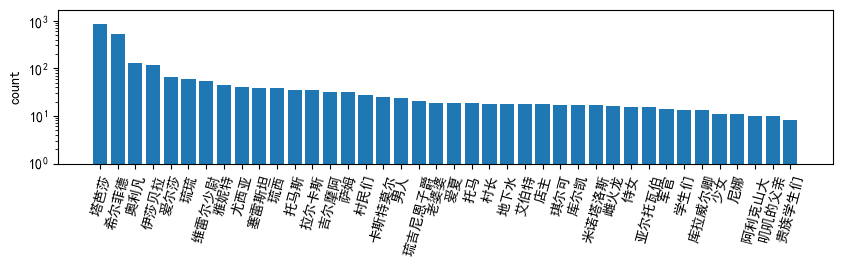

list of characters and their frequencies: {'塔芭莎': 852, '希尔菲德': 511, '奥利凡': 128, '伊莎贝拉': 116, '爱尔莎': 67, '琉琉': 60, '维雷尔少尉': 54, '雅妮特': 45, '尤西亚': 41, '塞雷斯坦': 39, '琉西': 39, '托马斯': 35, '拉尔卡斯': 35, '吉尔摩阿': 32, '萨姆': 31, '村民们': 28, '卡斯特莫尔': 25, '男人': 24, '琉吉尼恩子爵': 21, '老婆婆': 19, '爱夏': 19, '托马': 19, '村长': 18, '地下水': 18, '艾伯特': 18, '店主': 18, '琪尔可': 17, '库尔凯': 17, '米诺塔洛斯': 17, '雌火龙': 16, '侍女': 15, '亚尔托瓦伯': 15, '军官': 14, '学生们': 13, '库拉威尔卿': 13, '少女': 11, '尼娜': 11, '阿利克山大': 10, '叽叽的父亲': 10, '贵族学生们': 8, '贵族客人': 8, '魔法师': 8, '村民': 7, '雷昂': 7, '卫士': 7, '叽叽': 7, '弗雷姆': 7, '塔巴莎施': 7, '亚尔罗瓦伯': 6, '水兵': 6, '男子': 5, '塔芭萨': 5, '母亲': 5, '德·罗纳尔伯爵夫人': 5, '侍从': 5, '叽叽的母亲': 5, '伊尔库库': 5, '侍女娜塔莉': 4, '智慧短剑“地下水”': 4, '教师': 4, '其他学生': 4, '侍女们': 3, '萨姆哥哥': 3, '猎人们': 3, '翼人们': 3, '翼人': 3, '人群中一个人': 3, '女孩': 3, '杰伊克': 3, '短剑': 3, '吉尔摩阿老板': 3, 'null': 3, '粉发少女': 3, '小明': 3, '粗糙男': 2, '猎人': 2, '龙': 2, '龙形卡哥伊鲁': 2, '人群中另一个人': 2, '另一个人': 2, '亚历山大': 2, '卫队队长': 2, '娜塔莉': 2, '风龙': 2, '男孩儿': 2, '多米尼克婆婆': 2, '男人们': 2, '马尔特老

In [19]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams['font.sans-serif'] = ['SimHei']

rename_map={'塔巴萨':'塔芭莎','塔巴莎':'塔芭莎'}

# we use the original name in history text, but the new name for labeling

char_freq={}
for item in all_content:
    if 'char' in item:
        char=rename_map.get(item['char'], item['char'])
        if char not in char_freq:
            char_freq[char]=0
        char_freq[char]+=1
char_freq={k: v for k, v in sorted(char_freq.items(), key=lambda item: item[1], reverse=True)}
selected_char=list(sorted(char_freq.keys(), key=lambda x: char_freq[x], reverse=True)[:9999])

def list_char_items(content, char):
    for item in content:
        if item.get('char', None) == char:
            print(item)


plt.figure(figsize=(10, 2))
plt.bar(list(char_freq.keys())[:40], list(char_freq.values())[:40])
plt.xticks(rotation=75)
plt.ylabel('count')
plt.yscale('log')
plt.ylim(1,np.max(list(char_freq.values())[:20])*2)
plt.show()

print('list of characters and their frequencies:',char_freq)
print('rename_map:', rename_map)
print('selected_char:', selected_char)






### 提取表情，使用gpt聚类

In [20]:
# all_expressions=set(item['expression'] for item in all_content if 'expression' in item)
# print('all_expressions:', all_expressions)

unlabeled_expression_freq={}
for item in all_content:
    if 'expression' in item:
        unlabeled_expression_freq[item['expression']]=unlabeled_expression_freq.get(item['expression'], 0)+1
unlabeled_expression_freq={k: v for k, v in sorted(unlabeled_expression_freq.items(), key=lambda item: item[1], reverse=True)}

print('unlabeled_expression_freq:', unlabeled_expression_freq)

with open(unlabeled_expression_path, 'w', encoding='utf-8') as f:
    json.dump(unlabeled_expression_freq, f, ensure_ascii=False, indent=2)
print('saved unlabeled expressions to', unlabeled_expression_path)

unlabeled_expression_freq: {'惊讶': 37, '愤怒': 17, '哭泣': 8, '害怕': 7, '肯定': 6, '抱怨': 6, '高兴': 5, '生气': 5, '悲伤': 5, '紧张': 5, '抗议': 5, '惊恐': 5, '微笑': 5, '笑': 5, '疑惑': 4, '无表情': 4, '得意': 4, '不满': 4, '冷若冰霜': 4, '面无表情': 3, '满意': 3, '吃惊': 3, '无奈': 3, '恐惧': 3, '自信': 3, '解释': 3, '撒娇': 3, '慌张': 3, '兴奋': 3, '专注': 3, '咆哮': 3, '痛苦': 3, '点头': 2, '犹豫': 2, '满足': 2, '安心': 2, '快乐': 2, '嘲讽': 2, '哀求': 2, '苍白': 2, '不甘心': 2, '平淡': 2, '摇头': 2, '笑容': 2, '劝说': 2, '欢迎': 2, '大叫': 2, '否定': 2, '失望': 2, '思考': 2, '肚子饿了': 1, '打哈欠': 1, '愉悦的大笑': 1, '满脸歉意': 1, '无奈的笑着': 1, '嘲笑着塔巴莎': 1, '蔑视的笑容': 1, '担心': 1, '唱歌': 1, '咏唱咒文': 1, '悲哀': 1, '恳求': 1, '平静': 1, '丧气': 1, '毫无顾虑': 1, '好奇': 1, '孤寂的笑容': 1, '沮丧': 1, '歪头': 1, '饥饿': 1, '笑了起来': 1, '露出獠牙': 1, '坏笑': 1, '战战兢兢': 1, '不适': 1, '侧目': 1, '轻描淡写': 1, '疼痛': 1, '眯起眼': 1, '凑近艾尔莎': 1, '脸色变了，回复了以前的口气': 1, '注意到希尔菲德手上拿着魔杖': 1, '得意的挺起胸': 1, '脸色变了': 1, '鼓起了两腮': 1, '指着希尔菲德': 1, '脸上没有了血色': 1, '决然': 1, '严肃': 1, '天真': 1, '神秘': 1, '惊呆': 1, '粗鲁': 1, '凶狠': 1, '空虚': 1, '怒视塔芭莎': 1, '警惕': 1, '注视': 1, '不怀

In [24]:
from langchain.chains.base import Chain
import json
import re
from my_llm import llm_chatgpt as llm


class LabelExpressionChain(Chain):
    llm:object=None
    labels:list='平静，专注，微笑，兴奋，微怒，大怒，惊讶，恐惧，悲哀，哭泣，害羞，困惑，白眼'.split('，')
    @property
    def input_keys(self):
        return ['unknown_expression']
    @property
    def output_keys(self):
        return ['label']
    prmopt='''请将“{unknown_expression}”归类为下列类别中的一种：
{labels}
“{unknown_expression}”的类别是：'''
    def _call(self,inputs:dict)->dict:
        inputs['labels']=self.labels
        inputs['unknown_expression']=re.sub(r'[^\u4e00-\u9fa5]', '', inputs['unknown_expression'])
        if inputs['unknown_expression'] in self.labels:
            return {'label':inputs['unknown_expression']}
        query=self.prmopt.format(**inputs)
        response=self.llm(query)
        response=re.sub(r'[^\u4e00-\u9fa5]', '', response)
        if response not in self.labels:
            response=None
        return {'label':response}

label_expression_chain=LabelExpressionChain(llm=llm)

llm.show_query=llm.show_response=True
label_expression_chain('不耐烦')
llm.show_query=llm.show_response=False


请将“不耐烦”归类为下列类别中的一种：
['平静', '专注', '微笑', '兴奋', '微怒', '大怒', '惊讶', '恐惧', '悲哀', '哭泣', '害羞', '困惑', '白眼']
“不耐烦”的类别是：微怒


loaded expression_map from ./output_zero/expression_map.json


  0%|          | 0/164 [00:00<?, ?it/s]

failed 喜极而泣
喜极而泣 -> None
failed 担忧
担忧 -> None
emoji_freq: {'惊讶': 43, '平静': 40, '悲哀': 36, '大怒': 36, '微笑': 32, '困惑': 31, '恐惧': 30, '微怒': 28, '兴奋': 19, '专注': 14, '害羞': 9, '哭泣': 8, '白眼': 2}


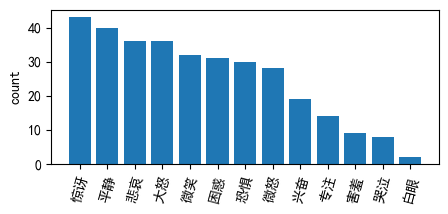

In [28]:
import os
from tqdm.auto import tqdm
if os.path.exists(expression_map_path):
    with open(expression_map_path, 'r', encoding='utf-8') as f:
        expression_map=json.load(f)
        print('loaded expression_map from', expression_map_path)
else:
    expression_map={}

for unknown_expression in tqdm(unlabeled_expression_freq):
    if expression_map.get(unknown_expression,None) is None:
        response=label_expression_chain(unknown_expression)
        if response['label'] is None:
            print('failed', unknown_expression)
        print(unknown_expression, '->', response['label'])
        expression_map[unknown_expression]=response['label']
        json.dump(expression_map, open(expression_map_path, 'w'),ensure_ascii=False,indent=4)

for item in all_content:
    if 'expression' in item and item['expression'] in expression_map and expression_map[item['expression']] is not None:
        item['emoji']=expression_map[item['expression']]

emoji_freq={}
for item in all_content:
    if 'emoji' in item:
        emoji_freq[item['emoji']]=emoji_freq.get(item['emoji'], 0)+1
emoji_freq={k: v for k, v in sorted(emoji_freq.items(), key=lambda item: item[1], reverse=True)}

print('emoji_freq:', emoji_freq)

plt.figure(figsize=(5, 2))
plt.bar(list(emoji_freq.keys()), list(emoji_freq.values()))
plt.xticks(rotation=75)
plt.ylabel('count')
# plt.yscale('log')
# plt.ylim(1,np.max(list(emoji_freq.values()))*2)
plt.show()


### 将chunk合并成章节

In [42]:
chapters=dict()

for iChunk,chunk in chunks.items():
    chapter=chapters.get(chunk['chapter_id'], {})
    chapter['chapter_id']=chunk['chapter_id']
    chapter['title']=chunk['title']
    chapter['chunk_ids']=chapter.get('chunk_ids', [])+[chunk['id']]
    chapter['chunk_summaries']=chapter.get('chunk_summaries', [])+[chunk['summary']]
    chapters[chunk['chapter_id']]=chapter

with open(chapter_summary_path, 'w', encoding='utf-8') as f:
    json.dump(chapters, f, ensure_ascii=False, indent=2)


# 使用FAISS知识索引为所有chunk生成参考词条

In [21]:
from langchain.embeddings import HuggingFaceEmbeddings
import sentence_transformers
from langchain.vectorstores import FAISS

embeddings = HuggingFaceEmbeddings(model_name=r'D:\ml\text2vec-large-chinese')
embeddings.client=sentence_transformers.SentenceTransformer(embeddings.model_name,device="cuda")

vector_store=FAISS.load_local(faiss_path, embeddings)

def get_bg_hint(context,max_text_len=500,k=25):
    results=vector_store.similarity_search(context,top_k=k)[:k]
    all_result_text=''
    for result in results:
        knowledge_item='【{0}】'.format(result.page_content)
        if len(all_result_text)+len(knowledge_item)+1>max_text_len:
            break
        all_result_text=all_result_text+knowledge_item+'\n'
    return all_result_text

dialogue='才人：起床了！\n路易斯：'
bg_hint=get_bg_hint(dialogue,max_text_len=500)
print(bg_hint)
# # llm(bg_hint+'\n请扮演路易斯\n'+dialogue)

No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.
No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.


【平贺才人 已与露易斯同居中。同时被书中许多女性角色爱慕著。喜欢露易丝。】
【露易丝 性格易怒，容易骂人，有点糊涂（跟才人比），为了小事常常生气。 动画第三期中为救出塔巴萨而放弃贵族身份，但被公主赏识，成为王位继承人。喜欢平贺才人。】
【露易丝 实际上是少见的“虚无”系统的魔法师（虚无使用者），只要情绪起伏大就能蓄积大量魔力。 性格易怒，容易骂人，有点糊涂（跟才人比），为了小事常常生气。】
【零之使魔 以住宿制的特里斯汀魔法学院为舞台，作为使魔的平贺才人开始了他倍受一副主人模样的美少女魔法使路易丝打骂、调教以及疼爱，充满勇气和屈辱的令人心动的学园生活……】



In [22]:
from tqdm.auto import tqdm
for iChunk,chunk in tqdm(chunks.items(), total=len(chunks)):
    chunk['bg_hint']=get_bg_hint(chunk['summary'],max_text_len=int(max_bg_tokens/token_per_char))
    
for chunk in random.sample(list(chunks.values()), 3):
    print(chunk['summary'])
    print(chunk['bg_hint'])

  0%|          | 0/240 [00:00<?, ?it/s]

塔巴莎和希尔菲德在床上谈论米诺塔洛斯的危险性，塔巴莎告诉希尔菲德即使使用风之刃也无法对付米诺塔洛斯。叽叽敲门告诉他们米诺塔洛斯又出现了，塔巴莎表示这不是叽叽一个人的问题。
【塔巴萨 而中了水魔法之毒而变得疯癫（后来约瑟夫战死后得到解药恢复心智），所以塔巴萨一直都封闭自己的话语和表情，】
【谢斯塔 谢斯塔的本性善良温和，但只要牵扯到与才人恋爱有关的事物，就会展现出平时没有的积极及勇气，甚至可以称之为激烈的性格。】
【塔巴萨 塔巴萨是她的别名（是她妈妈送给她的玩偶名字），其真名为夏洛特·埃里努·奥尔良。她妈妈因为要保护塔巴萨而中了水魔法之毒而变得疯癫（后来约瑟夫战死后得到解药恢复心智），所以塔巴萨一直都封闭自己的话语和表情】

这个小说片段讲述了一起吸血鬼杀人案件的调查过程。尽管房间的门窗都被锁住，但吸血鬼仍然能够进入房间吸取受害者的鲜血。调查人员发现这是利用“睡眠”原住魔法让人们睡着后再吸血的。然而，他们仍然不知道吸血鬼是如何进入房间的，因为房间没有任何入侵的痕迹。最后，调查人员发现了烟囱里的煤灰，暗示吸血鬼可能是从烟囱进入的。
【德鲁弗林加 具有吸收风、火、水、土等魔法的能力，而此能力在与华都对战时得到觉醒。并且能将吸收到的魔法力量转而驱动使用者身体的力量；而此能力曾在才人阻挡七万大军时失去意识而使用，亦因此才人才能得救。】
【安丽埃塔 在小说第四集绑架事件落幕后，安丽埃塔对于数次拯救她和国家危机的才人逐渐倾心，在第4部动画里曾用魔法镜子到才人密室而跟才人接吻，也让露易丝和谢丝坦感受到严重的危机威胁。】

娜塔莉在睡觉时被施加了魔法，塔芭莎让她回自己房间去，同时担心被自己人袭击。卫士们回到哨所后，杰伊克对公主的奇怪行为感到困惑，但不愿透露。公主一行人到达格尔诺普尔镇，受到欢迎，亚尔托瓦伯亲自迎接。
【安丽埃塔 在小说第四集绑架事件落幕后，安丽埃塔对于数次拯救她和国家危机的才人逐渐倾心，在第4部动画里曾用魔法镜子到才人密室而跟才人接吻，也让露易丝和谢丝坦感受到严重的危机威胁。】
【蒂法妮娅 才人为了阻止蒂法被审问与“贝儿朵莉丝”求情，“贝儿朵莉丝”不同意，于是才人便对其出手，与其龙骑士团对抗，露易丝正在做美梦被打斗的声音吵醒，出现在众人前用虚无魔法阻止了众人，】



# 生成训练数据

### 跑团式的回复文本

In [33]:
def generate_line(item):
    if 'info' in item:
        return '【'+item['info']+'】'
    if 'char' in item:
        char=rename_map.get(item['char'], item['char'])
        if 'act' in item:
            return char+'：'+'\\me '+item['act']
        emoji_text=('\\emoji '+item['emoji']) if 'emoji' in item else ''
        say_text=item['say'] if 'say' in item else ''
        think_text=('（'+item['think']+'）' if '（' not in item['think'] else item['think']) if 'think' in item else ''
        return char+'：'+say_text+think_text+emoji_text
    
def generate_chapter_title(title):
    return '='*10+title+'='*10

all_log_text=''
prev_chapter_id=None
for item in tqdm(all_content):
    chunk=chunks[item['src_id']]
    if prev_chapter_id!=chunk['chapter_id']:
        all_log_text+=generate_chapter_title(chunk['title'])+'\n'
        prev_chapter_id=chunk['chapter_id']
    line=generate_line(item)
    if line is not None:
        all_log_text+=line+'\n'

with open(text_log_path, 'w', encoding='utf-8') as f:
    f.write(all_log_text)

  0%|          | 0/3513 [00:00<?, ?it/s]

### 生成给定位置看到的跑团记录

In [80]:


def generate_history_text(content:'list[dict]',mode='full',max_history_tokens=max_history_tokens,bg_hint_num=0):
    if bg_hint_num>0:
        tmp_history_text=generate_history_text(content,mode='full',max_history_tokens=max_history_tokens,bg_hint_num=0)
        bg_hint_text=get_bg_hint(tmp_history_text,k=bg_hint_num)+'\n'
    else:
        bg_hint_text=''
    if mode=='full':
        all_text=''
        for item in content[-1::-1]:
            if 'char' in item:
                line=f'{item["char"]}：'+generate_response_text(item)
            elif 'info' in item:
                line=f'【{item["info"]}】'
            else:
                continue
            if estimate_tokenized_length(bg_hint_text+all_text+line+'\n')>max_history_tokens:
                break
            else:
                all_text=line+'\n'+all_text
        return bg_hint_text+all_text
    elif mode=='prev_dialogue':
        for item in content[-1::-1]:
            if 'char' in item and 'say' in item:
                return bg_hint_text+item['say']+'\n'
        return ''
    elif mode=='none':
        return ''
    else:
        raise ValueError(f'Unknown mode: {mode}')

print('mode=none')
print(repr(generate_history_text(all_content[:331], mode='none')))
print('mode=prev_dialogue')
print(generate_history_text(all_content[:331], mode='prev_dialogue',bg_hint_num=3))
print('mode=full')
histoy_text=generate_history_text(all_content[:331], mode='full',bg_hint_num=2)
print(histoy_text)

all_history=generate_history_text(all_content, mode='full', max_history_tokens=1e99)
with open(merged_history_path, 'w', encoding='utf-8') as f:
    f.write(all_history)
print('history text length (character):', len(all_history))
print('saved history text to', merged_history_path)

mode=none
''
mode=prev_dialogue


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:34                                                                                   │
│ in generate_history_text:3                                                                       │
│ in generate_history_text:11                                                                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'generate_response_text' is not defined

### 生成训练条目

我想让ChatGLM模型学习小说里的角色设定，并尝试扮演该角色。我准备的训练数据有。1.利用ChatGPT将小说文本转换成TRPG跑团记录格式。2.让ChatGPT阅读文本并生成对小说角色的模拟采访。

可以选择在prompt中加入较长的历史上下文，或者只提供问句，甚至不提供。简单的训练（抱歉没有等到收敛）表明，如果不提供上下文让模型生成角色的下一步言行会让模型倾向于使用“嗯”，“好的”。一类的回答。这是因为在原则上没有足够找到正确答案的上下文信息时摆烂是最稳妥的。

但是我希望模型能够尝试不依靠上下文提示自己记忆背景信息，可能即使有上下文时模型仍然需要记忆一些东西才可以生成正确的回复。

我希望额外加入的问答训练能够帮助模型保持ChatGLM的智力。在使用ChatGPT蒸馏数据以微调ChatGLM时，这些问答数据确实是ChatGPT仅仅根据窗口中的上下文推断出来的。那么是否应该把窗口中的上下文包括在prompt中呢？ChatGPT建议保持上下文信息数量适当可防止模型过度依赖上下文。

In [11]:
all_interview[13]

{'respondent': '玩偶',
 'ask': '你们觉得我和铁珠的关系怎么样？',
 'answer': '我们是密不可分的伙伴，一起立功。',
 'src_id': 2}

In [12]:
assert False, 'TODO optimize faiss search'

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError: TODO optimize faiss search

In [27]:
from tqdm.auto import tqdm
def get_rp_task(all_content,history_mode='full',bg_hint_num=2,max_history_tokens=max_history_tokens,use_dm_prompt=True):
    train_data=[]
    for iItem, item in tqdm(list(enumerate(all_content))):
        if 'char' in item:
            char=rename_map.get(item['char'], item['char'])
            if char in selected_char:
                if 'say' in item or ('think' in item and include_think) or ('act' in item and include_act):
                    response_text=generate_response_text(item)
                    history_text=generate_history_text(all_content[:iItem],mode=history_mode,max_history_tokens=max_history_tokens,bg_hint_num=bg_hint_num)
                    dm_prompt=generate_dm_prompt(item) if use_dm_prompt else ''
                    prompt_text=history_text+dm_prompt+char+'：'
                    # prompt_text_tokenized_length=get_tokenized_length(prompt_text)
                    # assert prompt_text_tokenized_length<=max_prompt_tokens, f'prompt_text_tokenized_length={prompt_text_tokenized_length} > max_prompt_length={max_prompt_tokens}'
                    prompt_text,prompt_tokenized_length=clamp_by_tokenizer(prompt_text, max_prompt_tokens, return_length=True)
                    response_tokenized_length=get_tokenized_length(response_text)
                    train_data.append({'char':char, 'response': response_text,'prompt': prompt_text,'task':'rp','src_id':iItem,'prompt_tokenized_length':prompt_tokenized_length,'response_tokenized_length':response_tokenized_length})
    print('Total generated data:', len(train_data))
    return train_data


# {'respondent': '玩偶',
#  'ask': '你们觉得我和铁珠的关系怎么样？',
#  'answer': '我们是密不可分的伙伴，一起立功。',
#  'id': 2}

def find_content_with_id(id):
    for content in contents:
        if 'id' in content and content['id']==id:
            return content
    return None

def get_inteview_task(all_interview,history_mode='full',bg_hint_num=2,max_history_tokens=max_history_tokens):
    train_data=[]
    for iItem, item in tqdm(list(enumerate(all_interview))):
        content=find_content_with_id(item['src_id'])['content']
        assert content is not None, f'Cannot find content with id={item["id"]}'
        char=rename_map.get(item['respondent'], item['respondent'])
        if char in selected_char:
            response_text=item['answer']
            history_text=generate_history_text(content,mode=history_mode,max_history_tokens=max_history_tokens,bg_hint_num=bg_hint_num)
            interviewer_prompt=f'{get_random_inteviewer_name()}：{item["ask"]}\n'
            prompt_text=history_text+interviewer_prompt+char+'：'
            # prompt_text_tokenized_length=get_tokenized_length(prompt_text)
            # assert prompt_text_tokenized_length<=max_prompt_tokens, f'prompt_text_tokenized_length={prompt_text_tokenized_length} > max_prompt_length={max_prompt_tokens}'
            prompt_text,prompt_tokenized_length=clamp_by_tokenizer(prompt_text, max_prompt_tokens, return_length=True)
            response_tokenized_length=get_tokenized_length(response_text)
            train_data.append({'char':char, 'response': response_text,'prompt': prompt_text,'task':'interview','src_id':iItem,'prompt_tokenized_length':prompt_tokenized_length,'response_tokenized_length':response_tokenized_length})
    print('Total generated data:', len(train_data))
    return train_data


random.seed(42)
train_data=[]
train_data+=get_rp_task(all_content, history_mode='full',bg_hint_num=bg_hint_num, use_dm_prompt=False)
if include_interview:
    train_data+=get_inteview_task(all_interview, history_mode='full',bg_hint_num=bg_hint_num)


  0%|          | 0/22765 [00:00<?, ?it/s]

Total generated data: 12684


  0%|          | 0/8319 [00:00<?, ?it/s]

Total generated data: 7576


<Figure size 500x200 with 0 Axes>

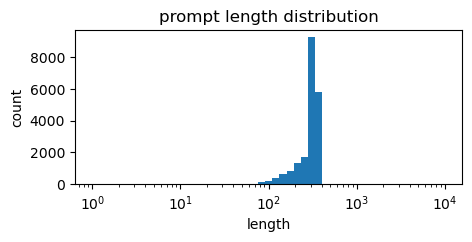

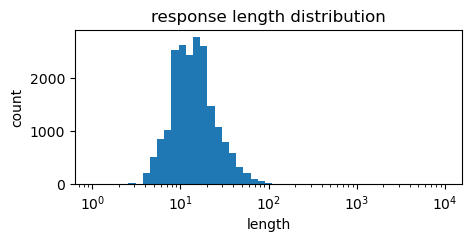

In [28]:
import matplotlib.pyplot as plt

# see prompt length distribution
plt.figure(figsize=(5, 2))
plt.hist([item['prompt_tokenized_length'] for item in train_data], bins=np.logspace(0, 4, 50))
plt.xscale('log');plt.xlabel('length');plt.ylabel('count');plt.title('prompt length distribution');plt.show()

# see response length distribution
plt.figure(figsize=(5, 2))
plt.hist([item['response_tokenized_length'] for item in train_data], bins=np.logspace(0, 4, 50))
plt.xscale('log');plt.xlabel('length');plt.ylabel('count');plt.title('response length distribution');plt.show()

### 调整数据频率

In [43]:

def adjust_data_frequency(train_data):
    for item in train_data:
        frequency=1
        if len(item['response'])<5:
            frequency=0.1
        elif len(item['response'])<10:
            frequency=0.2
        elif len(item['response'])<20:
            frequency=1
        elif len(item['response'])<50:
            frequency=2
        else:
            frequency=5
        if item['task']=='interview':
            frequency*=len(all_content)/len(all_interview)/roleplay_propotion*interview_propotion
        frequency*=1
        for _i in range(int(frequency)):
            yield item    

train_data_argumented=list(adjust_data_frequency(train_data))



for item in random.sample(train_data_argumented, 10):
    print(item['prompt'][-50:], end='》》')
    print(item['response'])
    print()


    
import random
random.seed(42)
random.shuffle(train_data_argumented)

成这样？自己是不是也会变成这样？)
【深蓝色火粉沾在他们身上】
记者：你们为什么要寻找我？
玛琼琳：》》我不知道，他们只是内心有一股冲动驱使他们去寻找我。

内，形貌便能‘自在’显现。
悠二：呼~恩，确实只要一提到与火有关的魔神，通常都回带着刀或剑。
悠二：》》(他对于‘魔神’的印象顶多是来自在国营电视台看过的不动明王，或者是过去不知名的特效电影中所出现的陶俑那一类的程度而已。)

… \emoji 害羞
悠二：吉田同学？ \emoji 惊讶
【夏娜是个火雾战士，比较冷淡】
吉田：》》那……那个，小缘，刚刚，体育课的时候，真……谢谢你。 \emoji 害羞

涉别人的行动了？】
【既然左右双翼已经断了，那家伙也到此为止了】
评论员：你在回忆什么？
火雾战士：》》我在回忆一场兵荒马乱的战斗，一身黑衣飘扬的女子慢条斯理地说道：到这里就够了，接下来由我跟亚拉斯特尔来处理。

想，应该是我所编写的调音自在法，受到某种干扰的结果
【玛琼琳和某人在讨论扭曲现象的来源】
贝海默特：》》呼嗯，看来是这样没错，事实上，我们也大致猜到是哪个‘使徒’会做出这种事。

……那个，请问……
魔神：怎么了，还不快跑！
悠二：\me 横越马路
悠二：\me 跑上堤防
悠二：》》(一想到曾经在这里欣赏到的美景，这分差事便不觉得辛苦)

。】
梅利希姆：对，就像这样。
少女：！
少女：\me 感觉到梅利希姆体内凝聚了‘两股’力量
夏娜：》》(攻击力逐渐增强当中——)

…然后破坏现在这层才开始建立关系的话……)
【主角意识到自己的懦弱和半吊子的觉悟，感到自责】
主角：》》(自己对于坂井悠二繁荣感情，难道脆弱到仅仅因为内心一个忧虑，就准备打退堂鼓了吗？)

中燃烧着一团炽盛火焰，底部没有燃料，只有一个银制的空水盘】
问询人：你为什么要成为火雾战士？
夏娜：》》我一开始就是为了成为火雾战士而活，而且自己并没有感到任何不满，这一切她都明白。同时也在学习之中得知，成为火雾战士就不再是人类，永无至尽的战斗之路，以及战斗这件事情本身。尽管内心对于这一切怀抱着不安、恐惧、踌躇，却还是充满了坚强、冀望、渴求与决心。

了！
夏娜：\me 灌输翅膀的力量，加速前进
【巨狼踩碎大楼崩坍的屋顶，瓦砾掉落在两人头上】
巨狼：》》咆噢噢噢噢噢噢噢噢噢！！



### 保存训练数据到json

In [44]:
#pick test data randomly
output_test_data=random.sample(train_data_argumented, test_data_size)

# remove test data from train data
output_train_data=[item for item in train_data_argumented if item not in output_test_data]

json.dump(output_train_data, open(train_data_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
print('Saved to', train_data_path)
print('Total train data:', len(output_train_data))
import random
random.seed(42)

json.dump(output_test_data, open(test_data_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
print('Saved to', test_data_path)
print('Total test data:', len(output_test_data))

Saved to ./train.json
Total train data: 31640
Saved to ./test.json
Total test data: 200


# trash code

In [ ]:
# import json,random
# from glob import glob


# def purge_content1(content):
#     for item in content:
#         if 'char' in item:
#             char_and_exp={'char':item['char']}
#             if 'expression' in item:
#                 char_and_exp['expression']=item['expression']
#             if 'say' in item and item['say'] is not None and len(item['say'])>0:
#                 yield {**char_and_exp, 'say': item['say']}
#             if 'think' in item and item['think'] is not None and len(item['think'])>0:
#                 yield {'char': item['char'], 'think': item['think']}
#             if 'act' in item and item['act'] is not None and len(item['act'])>0:
#                 yield {**char_and_exp,  'act': item['act']}
#             # if not any(k in item for k in ['say', 'think', 'act']):
#             #     yield char_and_exp
#         if 'info' in item:
#             yield {'info': item['info']}

# # combine continuous say
# def purge_content2(content):
#     prev_item={}
#     for item in content:
#         if 'say' in item:
#             if 'say' in prev_item and item.get('char', 'ERROR1')==prev_item.get('char', 'ERROR2'):
#                 prev_item['say']+=item['say']
#                 continue
#         if len(prev_item)>0:
#             yield prev_item
#         prev_item=item
#     if len(prev_item)>0:
#         yield prev_item

# def purge_content(content):
#     return purge_content2(purge_content1(content))

# contents=[]
# for path in glob(f'{cache_dir}/LOG_RESPONSE_*.json'):
#     with open(path, 'r', encoding='utf-8') as f:
#         try:
#             content=json.load(f)
#             content['content']=list(purge_content(content['content']))
#             content['id']=int(path.split('_')[-1].split('.')[0])
#             for item in content['content']:
#                 item['src_id']=content['id']
#             contents.append(content)
#         except Exception as e:
#             print('Error:', path, e)
#             raise e
# contents=sorted(contents, key=lambda x: x['id'])


# all_content=[]
# for content in contents:
#     for item in content['content']:
#         all_content.append(item)

# for item in random.sample(all_content, 10):    
#     print(item)
    
# print('Total content chunks:', len(contents))
# print('Total items:', len(all_content))

# json.dump(all_content, open(merged_content_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)

{'char': '悠二', 'act': '被甩来甩去，受到音波挤压翻搅', 'src_id': 264}
{'info': '各俱乐部和班级也将各种模拟店的摊子摆了起来，展示的摊位一直向学校外面的大路上延伸开去。', 'src_id': 1634}
{'char': '男子', 'say': '想打倒我千变修德南，还嫌太嫩！', 'src_id': 394}
{'info': '成为一个真正的敌人', 'src_id': 614}
{'info': '蒂丽亚把这个反应视为完全放弃挣扎，于是志得意满的宣布处刑方式：', 'src_id': 456}
{'char': '悠二', 'think': '对于之前好不容易克服了痛苦至极的烦恼才向吉田表明的秘密，现在居然随随便便公开宣扬的状况感到全身无力。', 'src_id': 848}
{'char': 'unknown', 'think': '只要是他塑造出来的妄想一律满足，许他恣意玩乐。', 'src_id': 1596}
{'char': '佐腾启作', 'expression': '惊讶', 'say': '坂井你那副打扮是怎么回事.?', 'src_id': 909}
{'info': '千草一副惊异的样子，把手掌贴在自己的脸上', 'src_id': 1041}
{'char': 'unknown', 'say': '哈哈哈哈', 'src_id': 1098}
Total content chunks: 1650
Total items: 22765


In [45]:
try:
    del tokenizer,embeddings,vector_store
except:
    pass
import torch
torch.cuda.empty_cache()

In [ ]:
!.\train_roleplaying.bat

In [ ]:
import random

def generate_response_text(item):
    if not 'char' in item:
        return ''
    response=''
    if 'act' in item:
        response='\me '+response+item['act']
    elif 'say' in item:
        response=response+item['say']
    elif 'think' in item:
        response='('+item['think']+')'
    if 'emoji' in item:
        response=response+f' \\emoji {item["emoji"]}'
    return response

def generate_dm_prompt(item):
    if 'act' in item:
        dm_prompt='【你接下来要做什么？】\n'
    elif 'say' in item:
        dm_prompt='【请发言】\n'
    elif 'think' in item:
        dm_prompt='【你现在在想什么？】\n'
    else:
        dm_prompt=''
    return dm_prompt

def get_random_inteviewer_name():
    names = ['记者', '采访者', '用户', '问询人', '主持人', '调查员', '新闻工作者', '播报员', '评论员', '撰稿人', '媒体工作者', '采写员']
    return random.choice(names)

for item in random.sample(all_content, 10):
    if 'char' in item:
        print(generate_response_text(item))

在本卷中登场的‘穿彻之洞’亚纳贝尔古先生也是其中的一人吗？
我知道。可是，这也是没办法的事啊？
欢迎来到修罗之巷，战斗之庭，我的火雾战士。
你啊！ \emoji 大怒
\me 以一个漂亮的抛物线落下来，稳稳地站在周围略高一点的建筑物上
悠二。你，是在我身边的存在。
(我没什么资格教训宰相殿下了)
啊啊，我来说明……对方所利用的应该是卡达修的血印——也就是我们用来调音的自在式吧，原本是让这个世界的运作朝着和谐的方向重新组合，不过目前看来，这个力量已经完全失去控制了。
